In [2]:
using LinearAlgebra
using Random, Distributions
using MLJ
using DataFrames
using MLJLinearModels
using Plots

In [1]:
include("srfe.jl")
using .srfe

In [3]:
K = 3
r = 2
λ = 3
c = false
func = rff

msq1 = MSQ(;K=K)
betaq = βQ(;β=1.2,λ=λ,K=K,condense=c);
sdq = ΣΔQ(;K=3,r=2,condense=false,λ=3);

model = srfeRegressor(;N= 1000, λ= 0.003, q= 0, func = rff, σ2 = 1, pruning=1.0);


In [4]:
using Convex, SCS

In [18]:
function LassoEN(Y, X, λ = 1;max_iters=10000)
    (T, K) = (size(X, 1), size(X, 2))

    Q = X'X / T
    c = X'Y / T                      #c'b = Y'X*b

    b = Variable(K)              #define variables to optimize over
    L1 = quadform(b, Q)            #b'Q*b
    L2 = dot(c, b)                 #c'b
    L3 = norm(b, 1)                #sum(|b|)

    if λ > 0
        Sol = minimize(L1 - 2 * L2 + λ * L3)      #u'u/T + λ*sum(|b|), where u = Y-Xb
    else
        error("λ too small")
    end
    solver = SCS.Optimizer
    solve!(Sol, solver; silent_solver = true)
    Sol.status == Convex.MOI.OPTIMAL ? b_i = vec(Convex.evaluate(b)) : b_i = NaN

    return b_i
end

LassoEN (generic function with 2 methods)

In [44]:
function LassoQuantized(Y,X,λ,μ, quant::Quantizer)
    # λ controls sparsity
    # μ controls resistancy to quantization. μ = 0 is normal lasso

    (T, K) = (size(X, 1), size(X, 2))

    E = X - quantize(quant,X)
    Q = (X'X + μ * E'E) / T
    c = X'Y / T                      #c'b = Y'X*b

    b = Variable(K)              #define variables to optimize over
    L1 = quadform(b, Q)            #b'Q*b
    L2 = dot(c, b)                 #c'b
    L3 = norm(b, 1)                #sum(|b|)

    if λ > 0
        Sol = minimize(L1 - 2 * L2 + λ * L3)      #u'u/T + λ*sum(|b|), where u = Y-Xb
    else
        error("λ too small")
    end
    solver = SCS.Optimizer
    solve!(Sol, solver; silent_solver = true)
    Sol.status == Convex.MOI.OPTIMAL ? b_i = vec(Convex.evaluate(b)) : b_i = NaN

    return b_i
    
end

LassoQuantized (generic function with 1 method)

In [7]:
#srfe fitter using SCS optimizer (way slower but can change the function to be optimized)
function fit2(model::srfeRegressor,X,y;quantizer=nothing)
    #weights
    m,d = size(X)
    ω, ζ = gen_weights(model.N,d,model.q,model.σ2)
    #println("compute features")
    A = compute_featuremap(X,ω, model.func,ζ)

    if !isnothing(quantizer)
        A = quantize(quantizer,A)
        if quantizer.condense
            A = condense(quantizer,A)
        end
    end
    
    c = LassoEN(y,A,model.λ)
    prune!(c,model.pruning)
    return c, ω ,ζ
end

#srfe fit with quantized lasso
function fitq(model::srfeRegressor,X,y,μ;quantizer)
    #weights
    m,d = size(X)
    ω, ζ = gen_weights(model.N,d,model.q,model.σ2)
    #println("compute features")
    A = compute_featuremap(X,ω, model.func,ζ)
    
    c = LassoQuantized(y,A,model.λ,μ,quantizer)
    prune!(c,model.pruning)
    return c, ω ,ζ
end

fitq (generic function with 1 method)

In [8]:
using MLJ, DataFrames
#boston dataset
bX, bY = @load_boston
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
#bY = (bY .- mean(bY)) ./ std(bY)
(Xtrain, Xtest), (ytrain, ytest) = partition((bX, bY), 0.8, rng=123, multi=true)

(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.5071204568645706 -0.13973526999215344 … 2.0856483230744165 -0.4765135961315187; -0.45784081189620396 -0.5073242348197996 … 1.595551981423302 -0.3308815317025295], [-0.507019470150779 -0.5073242348197996 … 2.117929317622008 -0.4170310181866815; -0.438932637054685 -0.5073242348197996 … 2.0303763096357867 -0.38682188871357304; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  36.2, 20.7, 42.3, 5.0, 18.7, 19.6, 17.9, 41.7, 31.2, 17.2], [23.3, 14.6, 32.0, 22.6, 14.1, 19.1, 20.3, 12.6, 50.0, 24.8  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

# Unquantized

Relative Error: 0.10544198394744508, Training Error: 0.09899470349556944
Absolute Error: 2.1344344835208915, Abs Training Error: 1.9402044254717368


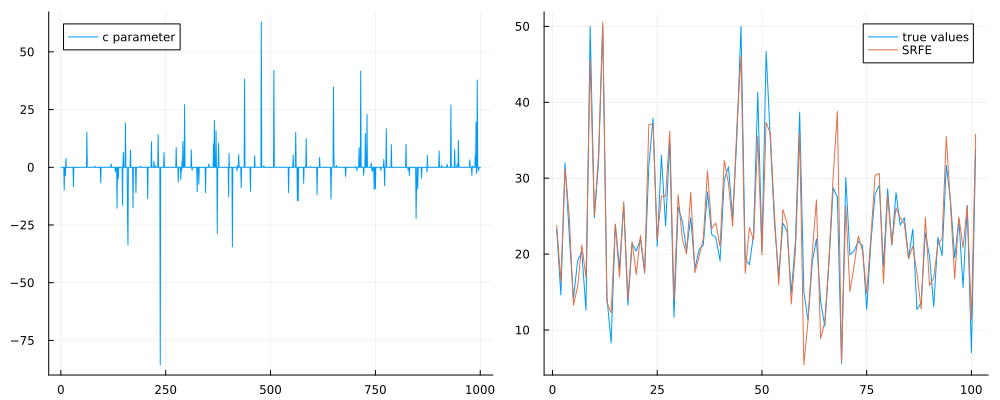

In [19]:
sdq = ΣΔQ(;K=3,r=2,condense=false,λ=3);
model = srfeRegressor(;N= 1000, λ= 0.003, q= 0, func = rff, σ2 = 1, pruning=1.0);

c, ω, ζ = fit2(model,Xtrain,ytrain;quantizer=nothing)
y_pred = compute_featuremap(Xtest,ω,func,ζ) * c
y_trainpred = compute_featuremap(Xtrain,ω,func,ζ) * c
println("Relative Error: $(rel_error(ytest,y_pred)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))

# Quantized naiv

Relative Error: 0.2101325292591279, Training Error: 0.22154982893650307
Absolute Error: 4.721567538876419, Abs Training Error: 4.817460503633814


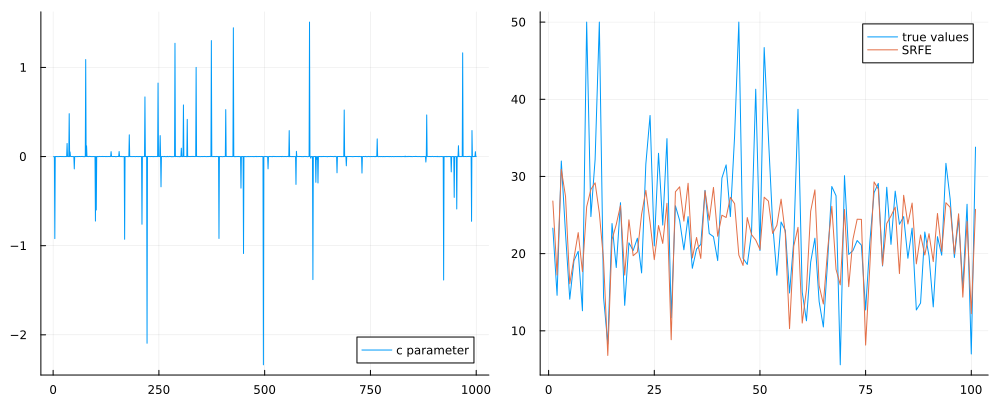

In [20]:
sdq = ΣΔQ(;K=3,r=1,condense=false,λ=3);
model = srfeRegressor(;N= 1000, λ= 1.2, q= 0, func = rff, σ2 = 1, pruning=1.0);

c, ω, ζ = fit2(model,Xtrain,ytrain;quantizer=sdq)
y_pred = quantize(sdq,compute_featuremap(Xtest,ω,func,ζ)) * c
y_trainpred = quantize(sdq,compute_featuremap(Xtrain,ω,func,ζ)) * c
println("Relative Error: $(rel_error(ytest,y_pred)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))

# Fitting the robust quantized model

Relative Error: 0.1803089519081589, Training Error: 0.22476988528550174
Absolute Error: 4.0332851978491515, Abs Training Error: 4.8229470016071945
---
Relative Quantized Error: 0.20720430486320102
Absolute Quantized Error: 4.495683141098146


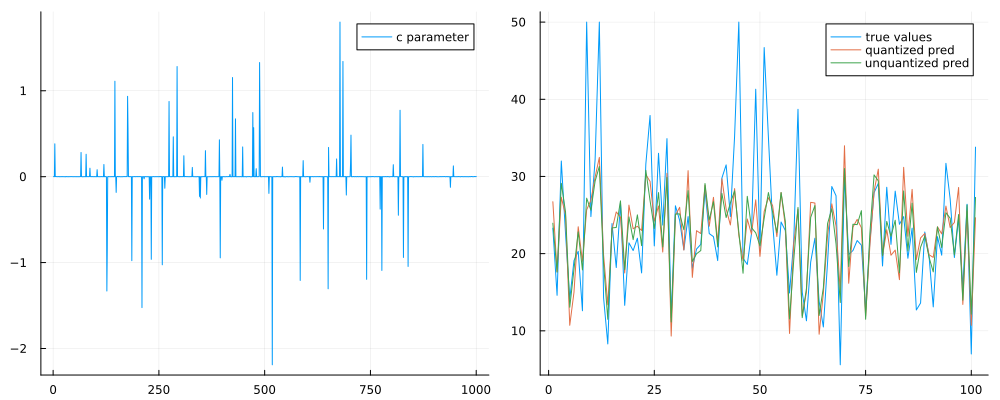

In [50]:
sdq = ΣΔQ(;K=3,r=1,condense=false,λ=3);
model = srfeRegressor(;N= 1000, λ= 0.5, q= 0, func = rff, σ2 = 1, pruning=1.0);
μ=0.5
c, ω, ζ = fitq(model,Xtrain,ytrain,μ;quantizer=sdq)
y_pred_quant = quantize(sdq,compute_featuremap(Xtest,ω,func,ζ)) * c
y_pred_unquant = compute_featuremap(Xtest,ω,func,ζ) * c
y_trainpred = compute_featuremap(Xtrain,ω,func,ζ) * c
println("Relative Error: $(rel_error(ytest,y_pred_unquant)), Training Error: $(rel_error(ytrain,y_trainpred))")
println("Absolute Error: $(mean(abs.(ytest-y_pred_unquant))), Abs Training Error: $(mean(abs.(ytrain-y_trainpred)))")
println("---")
println("Relative Quantized Error: $(rel_error(ytest,y_pred_quant))")
println("Absolute Quantized Error: $(mean(abs.(ytest-y_pred_quant)))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred_quant, label="quantized pred")
plot!(y_pred_unquant, label="unquantized pred")
plot(p1,p2,layout=2,size=(1000,400))

# parameter study

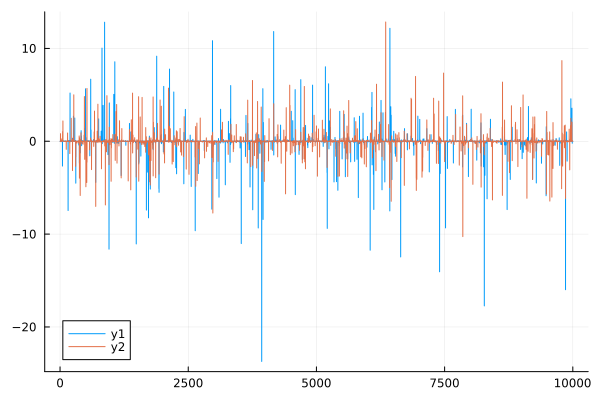

In [67]:
#input
X = Xtrain
Y = ytrain
model = srfeRegressor(;N= 10000, λ= 0.5, q= 0, func = rff, σ2 = 1, pruning=1.0);
sdq = ΣΔQ(;K=19,r=1,condense=false,λ=3);
msq = MSQ(;K=20)
#weights
m,d = size(X)
ω, ζ = gen_weights(model.N,d,model.q,model.σ2)
A = compute_featuremap(X,ω, model.func,ζ)
Q = quantize(msq,A)


lasso = LassoRegression(0.003; fit_intercept=false)
lasso_q = LassoRegression(0.003; fit_intercept=false)
solver = FISTA(max_iter=20000)
c = MLJLinearModels.fit(lasso,A,Y;solver)
c_quantized = MLJLinearModels.fit(lasso_q,Q,Y;solver)

plot(c)
plot!(c_quantized .* 1)
